# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построит модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Импортируем необходимые библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
PATH = '/datasets/faces/final_files/'
SEED = 12345

## Исследовательский анализ данных

Выполним загрузку данных:

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=PATH,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Выведем общую инфрмацию о датасете

In [4]:
display(labels.sample(5, random_state = SEED))
print('размер выборки: ', labels.shape)
print('Общая информация о выборке:')
print(labels.info())
labels.describe()

,file_name,real_age
5370,005370.jpg,50
4516,004516.jpg,41
3968,003968.jpg,46
2188,002188.jpg,85
5833,005833.jpg,14


размер выборки:  (7591, 2)
Общая информация о выборке:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В выборке найдено 7591 изображения с указанием возраста. Рассмотрим, как распределены возрасты в выборке:

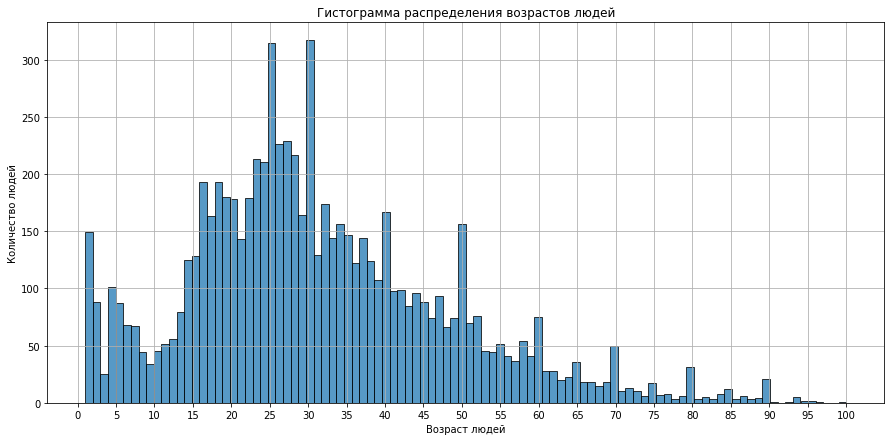

In [5]:
plt.figure(figsize=(15,7))
sns.histplot(labels.real_age, bins=100)
plt.title('Гистограмма распределения возрастов людей')
plt.grid()
plt.xlabel('Возраст людей')
plt.ylabel('Количество людей')
plt.xticks(range(0,105,5))
plt.show()

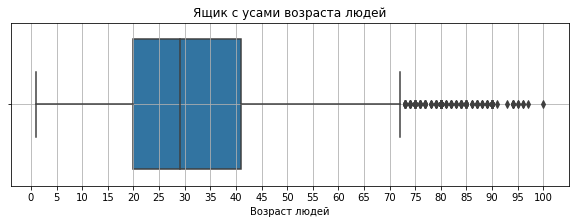

In [6]:
plt.figure(figsize=(10,3))
sns.boxplot(x = labels.real_age)
plt.title('Ящик с усами возраста людей')
plt.grid()
plt.xlabel('Возраст людей')
plt.xticks(range(0,105,5))
plt.show()

Мы видим, что распределение немного смещено вправо, присутсвуют выбросы - к таким значениям относятся люди в возрасте за 70 лет.
В датасете преобладают фотографии людей 20-30 лет, также довольно много фотографий детей до 5 лет, количество фотографий подростков десяти лет минимально, но плавно растет до 18 лет. Также наблюдаются явные пики каждое на десятиления: 40, 50, 60, 70, 80, 90. Возможно, что датасет размечался людьми.

Рассмотрим 15 случайных фотографий из датасета. Вывод картинок на экран осуществим с помощью функции `plot_image_grid`

In [7]:
def plot_image_grid(path: str, labels, grid_shape):    
    """
    path - путь до фотографий
    labels - датафрейм
    grid_shape - размер таблицы с картинками
    """
    fig, axs = plt.subplots(*grid_shape, figsize=(12, 10), constrained_layout=True)    
    for i, col in enumerate(axs):
        for j,row in enumerate(col):
            data = labels.iloc[i*grid_shape[1]+j]
            fname = path + data['file_name']
            with Image.open(fname) as im:
                row.imshow(im)
            row.set_title('Real age: ' + str(data['real_age']))
    plt.suptitle('15 случайных картинок',fontsize=20)
    plt.show()

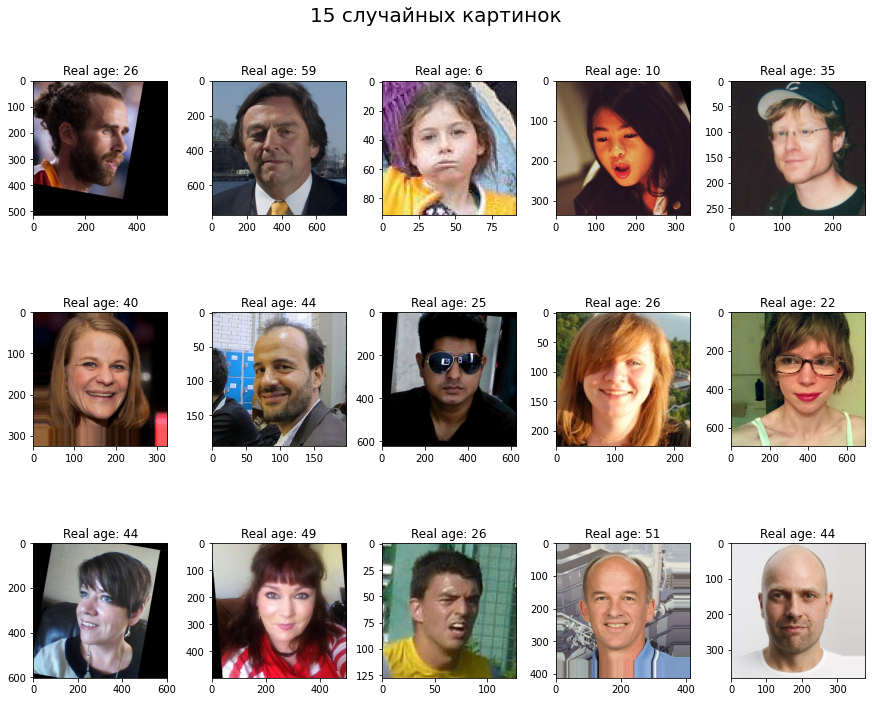

In [8]:
plot_image_grid(PATH, labels.sample(15), (3, 5))

**Вывод:**

Как можно видеть, в датасете содержатся совершенно разные фотографии людей разных возрастов: есть фотографии более и менее качественные, есть черно-белые, есть повернутые на небольшой градус. Картинки разных размеров

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
                          horizontal_flip=True,
                          validation_split=0.25,
                          rescale=1./255
                          )

    train_datagen_flow = (train_datagen.flow_from_dataframe(
                          dataframe=labels, 
                          directory=path + 'final_files/',
                          x_col='file_name', 
                          y_col='real_age', 
                          target_size=(224, 224), 
                          batch_size=8, 
                          class_mode='raw',
                          subset='training', 
                          seed=12345
                          )
    )
    return train_datagen_flow


def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
                          validation_split=0.25,
                          rescale=1/255.
                          )


    test_datagen_flow = (test_datagen.flow_from_dataframe(
                          dataframe=labels, 
                          directory=path + 'final_files/',
                          x_col='file_name', 
                          y_col='real_age', 
                          target_size=(224, 224), 
                          batch_size=8, 
                          class_mode='raw',
                          subset='validation', 
                          seed=12345)
    )

    return test_datagen_flow  

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr = 0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, epochs=40, batch_size=None,
               steps_per_epoch=None, validation_steps=None):

    train_datagen_flow = train_data
    test_datagen_flow = test_data


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    train_datagen_flow = train_data
    test_datagen_flow = test_data

    callbacks_custom = [
        callbacks.EarlyStopping(
            # Stop training when `val_mae` is no longer improving
            monitor="val_mae",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 6 epochs"
            patience=6,
            verbose=1
    )]
    model.fit(train_data, 
              validation_data=(test_data), epochs=epochs,
              steps_per_epoch=steps_per_epoch, batch_size=batch_size,
              validation_steps=validation_steps, 
              verbose=2, shuffle=True, callbacks= callbacks_custom)
    return model

```
# < результат вывода на экран сюда >

Train for 712 steps, validate for 238 steps
Epoch 1/40
712/712 - 69s - loss: 199.3190 - mae: 10.5472 - val_loss: 361.4787 - val_mae: 14.5100
Epoch 2/40
712/712 - 42s - loss: 96.1301 - mae: 7.5073 - val_loss: 98.1519 - val_mae: 7.4335
Epoch 3/40
712/712 - 42s - loss: 64.5882 - mae: 6.1559 - val_loss: 108.5245 - val_mae: 8.1008
Epoch 4/40
712/712 - 42s - loss: 50.8852 - mae: 5.4997 - val_loss: 73.1105 - val_mae: 6.3794
Epoch 5/40
712/712 - 42s - loss: 35.8018 - mae: 4.5979 - val_loss: 78.3428 - val_mae: 6.8117
Epoch 6/40
712/712 - 42s - loss: 30.1289 - mae: 4.2120 - val_loss: 88.6286 - val_mae: 7.1920
Epoch 7/40
712/712 - 42s - loss: 24.9385 - mae: 3.8500 - val_loss: 81.8224 - val_mae: 6.7844
Epoch 8/40
712/712 - 42s - loss: 21.7496 - mae: 3.5717 - val_loss: 74.9355 - val_mae: 6.5855
Epoch 9/40
712/712 - 42s - loss: 20.2870 - mae: 3.4291 - val_loss: 71.4545 - val_mae: 6.2756
Epoch 10/40
712/712 - 42s - loss: 18.1441 - mae: 3.2549 - val_loss: 71.4088 - val_mae: 6.2480
Epoch 11/40
712/712 - 42s - loss: 16.4586 - mae: 3.0923 - val_loss: 65.0482 - val_mae: 6.1142
Epoch 12/40
712/712 - 42s - loss: 15.9162 - mae: 3.0569 - val_loss: 68.8444 - val_mae: 6.1875
Epoch 13/40
712/712 - 42s - loss: 15.5076 - mae: 2.9773 - val_loss: 74.0259 - val_mae: 6.6585
Epoch 14/40
712/712 - 42s - loss: 13.2912 - mae: 2.7905 - val_loss: 75.6879 - val_mae: 6.4251
Epoch 15/40
712/712 - 42s - loss: 12.2081 - mae: 2.6609 - val_loss: 74.0275 - val_mae: 6.4281
Epoch 16/40
712/712 - 42s - loss: 12.7125 - mae: 2.7253 - val_loss: 74.6384 - val_mae: 6.6248
Epoch 17/40
712/712 - 42s - loss: 12.0520 - mae: 2.6569 - val_loss: 69.6994 - val_mae: 6.2252
Epoch 00017: early stopping
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 10s - loss: 69.6994 - mae: 6.2252
Test MAE: 6.2252

```

## Анализ обученной модели

Можно видеть, что в целом модель ошибается на 6.2252 года, что в целом может покрыть поставленные цели:

Обучение модели автоматически завершилось на 17-й эпохе автоматически. За основу нейронной сети была взята сеть ResNet50. Были инициализированы веса ImageNet и  добавлен верхний полносвязный слой с функцией активации ReLu. Функция потерь была задана MSE, в качестве оптимизатора был взят Adam c начальным шагом спуска 0.0001.

Можно видеть, что модель довольно сильно переобучается: MAE на тестовой почти в 2 раза больше, чем на обучающей. В принципе, это свойственно нейронным сетям с большим количеством слоев (а 50 - это довольно много). Причем можно видеть, что чем больше эпох и чем лучше результат на обучающей выборке, тем сильнее переобучается модель.

В случае, когда необходимо определить можно ли продавать потенциальному покупателю алкоголь, наша модель может дать рекомендацию: стоит ли спросить паспорт. С учётом ошибки предсказания необходимо рекомендовать спрашивать паспорт не только у тех, кто попал в диапазон 18 лет +- MAE, но и (16 лет - 20 лет) +- MAE. Это обеспечит более качественное решение вопроса.

Так как наша модель должна работать в магазине, возможно есть смысл изменить задачу на категоризацию:
- несколько подгрупп детей (для рекомендаций товаров их родителям);
- подростки;
- старше 18;
- несколько групп среднего возраста;
- пожилые люди.